In [1]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# データ読み込み・前処理
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [3]:
# VGG16モデル構築 (転移学習)
input_tensor = Input(shape=(32, 32, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='sigmoid'))
top_model.add(Dropout(0.5))
top_model.add(Dense(10, activation='softmax'))
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))
for layer in model.layers[:15]:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# コンパイルと学習
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32, epochs=3, verbose=2)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1563/1563 - 31s - 20ms/step - accuracy: 0.4609 - loss: 1.5703 - val_accuracy: 0.6328 - val_loss: 1.0729
Epoch 2/3
1563/1563 - 21s - 13ms/step - accuracy: 0.6267 - loss: 1.1094 - val_accuracy: 0.6813 - val_loss: 0.9348
Epoch 3/3
1563/1563 - 21s - 14ms/step - accuracy: 0.6793 - loss: 0.9672 - val_accuracy: 0.7091 - val_loss: 0.8534


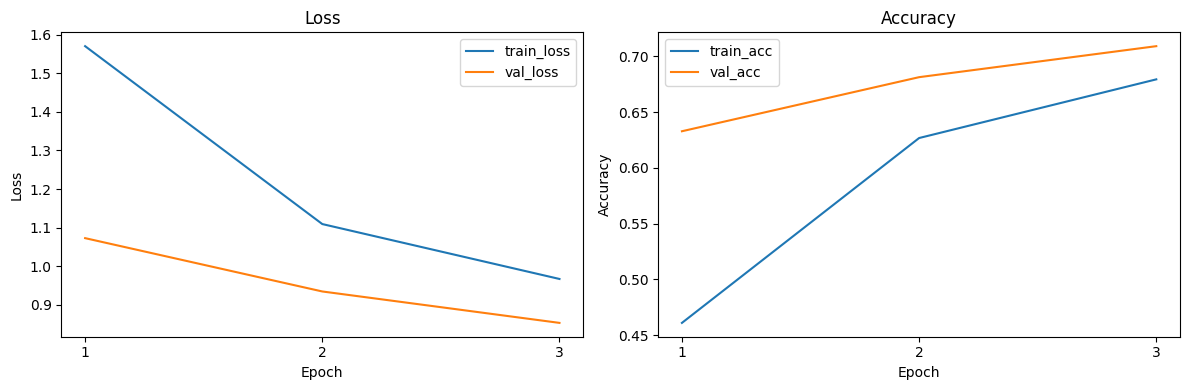

In [5]:
# 学習過程の可視化
epochs = 3
plt.figure(figsize=(12, 4))

# Lossグラフ
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), history.history['loss'], label='train_loss')
plt.plot(range(1, epochs+1), history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.legend()

# Accuracyグラフ
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), history.history['accuracy'], label='train_acc')
plt.plot(range(1, epochs+1), history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, epochs+1))
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# テスト精度の評価
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', scores[0])
print('Test Accuracy:', scores[1])

Test Loss: 0.8533721566200256
Test Accuracy: 0.7091000080108643


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10, 32, 32, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


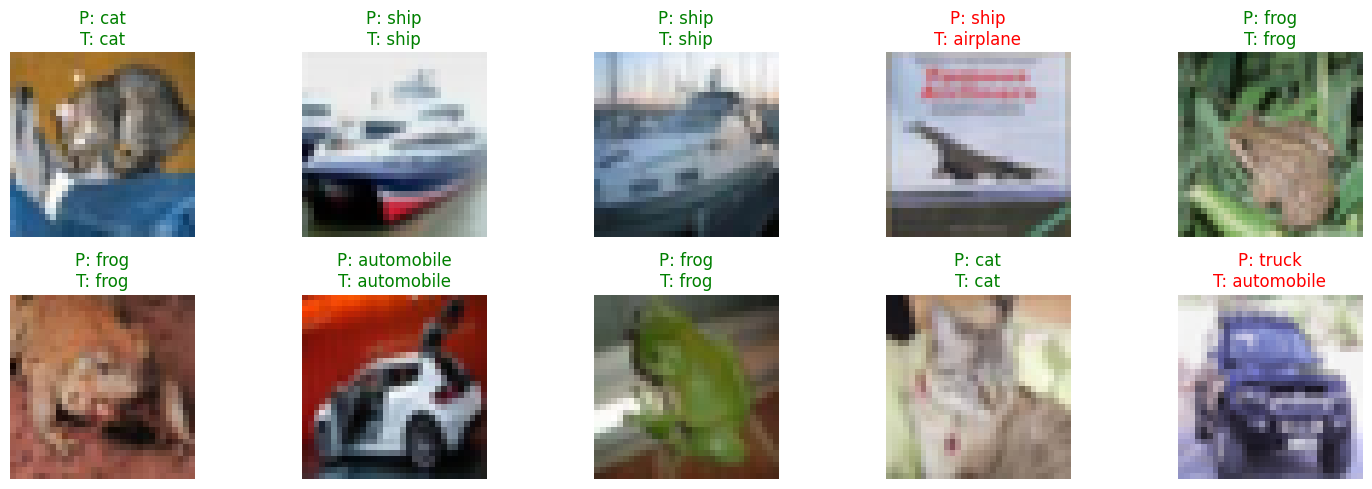

In [7]:
# 予測と画像の表示 (10枚)
predictions = model.predict(X_test[:10])
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i].astype("uint8"))
    pred_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[np.argmax(y_test[i])]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()